In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint as pp
import csv
import datetime
from dateutil.parser import parse
from pandas.tools.plotting import scatter_matrix
from patsy import dmatrices
import statsmodels.formula.api as smf

%matplotlib inline

In [54]:
complete_df = pd.read_csv("complete_post2010.csv")

In [55]:
complete_df = complete_df[np.isfinite(complete_df['comments_score'])]
complete_df = complete_df[np.isfinite(complete_df['posts_score'])]
complete_df = complete_df[np.isfinite(complete_df['foreign_gross'])]
complete_df = complete_df[np.isfinite(complete_df['opening_weekend'])]

complete_df["opening_weekend"] = complete_df["opening_weekend"].apply(lambda x: int(x))
complete_df["foreign_gross"] = complete_df["foreign_gross"].apply(lambda x: int(x))
# complete_df["release_date"] = complete_df["release_date"].apply(lambda x: parse(x).date())

complete_df = complete_df[complete_df['comments_score']>0]
complete_df = complete_df[complete_df['posts_score']>0]

# complete_df["reddit_buzz"]=complete_df['comments_score']*complete_df["posts_score"]
# complete_df = complete_df[complete_df['reddit_buzz']>0]


In [56]:
complete_df.describe()

,opening_weekend,foreign_gross,posts_score,comments_score
count,5.740000e+02,5.740000e+02,574.000000,574.000000
mean,2.250218e+07,1.103344e+08,5178.818815,31792.092334
std,2.728470e+07,1.585056e+08,6640.978680,49707.943219
min,4.712200e+04,6.300000e+02,1.000000,2.000000
25%,6.901067e+06,1.515000e+07,413.000000,1666.750000
50%,1.442660e+07,4.876004e+07,2275.000000,8881.000000
75%,2.733144e+07,1.296817e+08,7537.000000,42386.250000
max,2.074387e+08,9.605000e+08,34121.000000,394250.000000


KeyError: 'opening_weekend_adj'

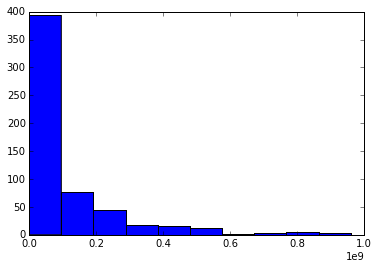

In [57]:
plt.hist(complete_df["foreign_gross"])
# plt.hist(complete_df["opening_weekend"])
plt.hist(complete_df["opening_weekend_adj"])

complete_df["opening_weekend_adj"] = complete_df['opening_weekend']*3

# complete_df.plot(x="opening_weekend_adj", y="foreign_gross", style='o')

complete_df[["opening_weekend_adj", "foreign_gross"]].plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a6e0a90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11b368b50>]], dtype=object)

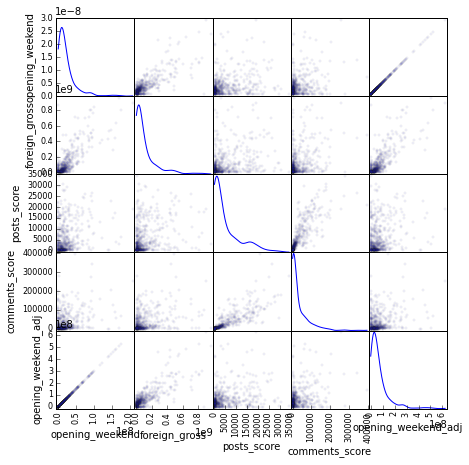

In [50]:
scatter_matrix(complete_df, alpha=0.05, figsize=(7,7), diagonal='kde')